# Proyecto 2 - Procesamiento de lenguaje natural
## CommonLit - Evaluate Student Summaries

**Francis Aguilar - 22243**<br>
**Diego García - 22404**<br>
**César López - 22535**<br>
**Ángela García - 22869**


Link del github:<br>
https://github.com/DiegoGarV/Proyecto2-DS

## Planteamiento inicial

1. Situación problemática:<br> 
En el ámbito educativo, la evaluación de resúmenes escritos por estudiantes suele ser un proceso manual, demandante y sujeto a la subjetividad del evaluador. Esto genera dificultades para proporcionar retroalimentación oportuna y consistente, especialmente en contextos con gran número de alumnos. El reto de CommonLit plantea la necesidad de desarrollar métodos automáticos de procesamiento de lenguaje natural (PLN) que apoyen la evaluación objetiva de los resúmenes en cuanto a contenido y calidad de redacción.

2. Problema científico:<br>
¿Es posible construir un modelo de PLN que, a partir del texto de un resumen y su prompt asociado, prediga con precisión las calificaciones de contenido y redacción, utilizando métricas cuantitativas como el MCRMSE para validar su desempeño?

3. Objetivo general:<br>
Desarrollar y evaluar un modelo de procesamiento de lenguaje natural capaz de predecir automáticamente las calificaciones de contenido y redacción en resúmenes estudiantiles, con el fin de apoyar la evaluación educativa de manera objetiva y eficiente.

4. Objetivos específicos:<br>
    i. Analizar el dataset de CommonLit para explorar las características lingüísticas y distribuciones de las calificaciones asociadas a los resúmenes.<br>
    ii. Implementar un sistema de representación textual y entrenar modelos de regresión basados en TF-IDF y algoritmos de aprendizaje supervisado.<br>
    iii. Validar el desempeño de los modelos utilizando validación cruzada y MCRMSE, comparando los resultados obtenidos con diferentes enfoques de modelado.

## Investigación preliminar

Las técnicas más comunes para la detección de patrones en procesamiento de lenguaje natural incluyen métodos estadísticos, representaciones vectoriales y modelos de aprendizaje automático. Entre las que más pueden aportar al proyecto son:

1. Análisis de frecuencia y n-gramas: permiten identificar qué palabras o combinaciones de palabras aparecen con mayor regularidad en los textos, revelando estructuras recurrentes y patrones de estilo.

2. Vectorización de texto (TF-IDF, embeddings): transforman el lenguaje en representaciones numéricas que capturan la importancia relativa de los términos o sus relaciones semánticas.

3. Modelos de clasificación o regresión supervisada: como regresión lineal, máquinas de soporte vectorial o redes neuronales, que aprenden patrones complejos para predecir etiquetas o puntajes a partir de los textos.

Estas técnicas pueden ayudar a extraer características del lenguaje en los resumenes estudiantiles y relacionarlos con las calificaciones de contenido y redacción. Los primeros dos ayudarán a facilitar la captura del vocabulario más característico de los resumenes y el último ayudará a asociar los patrones con el puntaje. De esta manera, se obtiene un sistema capaz de generalizar y evaluar automáticamente nuevos textos de manera objetiva y consistente.

## Análisis inicial del problema y los datos disponibles.



#### Descripción de la data

**summaries_train:**
- student_id: muestra el identificador único del estudiante.
- prompt_id: muestra el identificador único de la instrucción que se le dió al estudiante para hacer su resumen.
- text: el resumen hecho por el estudiante
- content: valor númerico continuo que representa la evaluación del resumen en que tan bien logra simplificar el texto el estudiante. Se toma en cuenta la coherencia, neutralidad, lógica y objetividad en el resumen.
- wording: valor numérico continuo que representa la evaluación del resumen en cuanto a la presentación de las ideas. Se enfoca en la redacción y el uso del lenguaje, más allá del contenido.

**prompts_train:**
- prompt_id: muestra el identificador único de la instrucción que se le dió al estudiante para hacer su resumen.
- prompt_title: título de la instrucción utilizada.
- prompt_question: la pregunta o instrucción específica que se le hizo al estudiante para poder generar su resumen.
- prompt_text: el texto completo que se debía resumir.

#### Consideraciones

La data muestra tanto textos como resumenes en inglés. Existen más de 7200 resumenes diferentes, pero están divididos en 4 textos(prompts). Es importante tener en cuenta, la vairación de longitud y el estilo en los resumenes. Además, en ellos puede existir faltas ortográficas que se tomarán como el ruido del dataset.

La escala original de content y wording debe ser preservada. Esto permitirá que el MCRMSE (promedio de RMSE) sea interpretable. Por lo tanto, no se normalizarán estos valores o los resultados de las metricas no darán la información que se busca.

Es importante destacar que la momento de entrenar al modelo, se debe de tomar en cuenta el prompt id tanto para separar los casos por pregunta, como para entender como diferentes preguntas pueden llevar a diferentes resultados de resumen. La diferencia en tamaño y complejidad entre prompts puede llegar a confundir al modelo si se llega a ignorar. 

#### Justificación de las técnicas de detección de patrones

**1. Análisis de frecuencia y n-gramas:**
 - Otorga una representación numérica, dispersa y eficiente que pondera términos discriminativos.
 - Ayudará a detectar marcadores de calidad como conectores, variedad léxica, etc. Además, permite tener una mayor idea de que palabras pueden asociarse a un mayor contenido o estilo.
 - Se debe de tener cuidado con el sobreajuste de los n-gramas, pues esto puede causar que solo se enfoque en un solo prompt. Para ello se harán validaciones por grupos y se limitaran las features.

**2. Vectorización con TF-IDF:**
 - Captura patrones léxicos básicos y compuestos.
 - Sus mayores beneficios serán el fuerte baseline en tareas de evaluación de texto con poco costo computacional. Además, permite integrar los n-gramas para capturar micro patrones de estilo y contenido.
 - Se debe tomar en cuenta que esta técnica no capta semántica profunda ni relaciones de largo alcance.

**3. Modelos supervisados:**
 - Permite mapear la representación TF-IDF a predicciones continuas con un sesgo y varianza controlados. 
 - Cuenta con un entrenamiento rápido y reproducible. Sus coeficientes permiten entender los resultados facilmente. Funciona bien con datos dispersos.
 - Se debe de tomar en cuenta los resultados del baseline para evitar errores si la relación entre el estilo y el contenido es no lineal.

In [2]:
# %pip install spacy
# %pip install unidecode

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import json
import re
import spacy
from unidecode import unidecode
import nltk
from nltk.corpus import stopwords

In [4]:
df_prompts_train = pd.read_csv("../data/prompts_train.csv")
df_summaries_train = pd.read_csv("../data/summaries_train.csv")

df_prompts_train.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already b...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background The Third Wave experiment took plac...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [5]:
df_summaries_train.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [6]:
# unir los dos dataframes por el id
df_merged = pd.merge(df_prompts_train, df_summaries_train, on="prompt_id")
df_merged.head()

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already b...,00791789cc1f,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415
1,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already b...,0086ef22de8f,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058
2,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already b...,0094589c7a22,Aristotle states that an ideal tragedy should ...,-0.387791,-0.584181
3,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already b...,00cd5736026a,One element of an Ideal tragedy is having a co...,0.088882,-0.594710
4,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already b...,00d98b8ff756,The 3 ideal of tragedy is how complex you need...,-0.687288,-0.460886


In [7]:
# !python -m spacy download en_core_web_sm

In [8]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

nlp = spacy.load("en_core_web_sm")


#preprocesamiento de texto
def preprocess_text(text, keep_punct=True, lemmatize=True, remove_stopwords=False):
    # pasar todo a minusculas
    text = text.lower()
    # quitar acentos
    text = unidecode(text)
    # eliminar caracteres raros pero conservar puntuación básica
    if keep_punct:
        text = re.sub(r"[^a-zA-Z\s.,;:!?]", "", text)
    else:
        text = re.sub(r"[^a-zA-Z\s]", "", text)
    # quitar espacios extra
    text = re.sub(r"\s+", " ", text).strip()

    # reemplazar la doble comilla por comillas simples
    text = text.replace('"', "'")


   # tokenizar y lematizar con spacy
    doc = nlp(text)
    tokens = []
    for token in doc:
        if remove_stopwords and token.text in stop_words:
            continue
        if lemmatize:
            tokens.append(token.lemma_)
        else:
            tokens.append(token.text)
    return " ".join(tokens)
# se usan otras columnas con el texto limpio, ya que si se quiere entrenar con el texto original, se puede usar esas columnas
# lemanizad sin stopwords y sin quitar puntuación
df_merged["clean_text"] = df_merged["text"].apply(preprocess_text)
df_merged["clean_prompt_question"] = df_merged["prompt_question"].apply(preprocess_text)
df_merged["clean_prompt_text"] = df_merged["prompt_text"].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
df_merged.head()

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording,clean_text,clean_prompt_question,clean_prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already b...,00791789cc1f,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415,element of an ideal tragedy be that it should ...,summarize at least element of an ideal tragedy...,chapter as the sequel to what have already be ...
1,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already b...,0086ef22de8f,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058,the three element of an ideal tragedy be : hav...,summarize at least element of an ideal tragedy...,chapter as the sequel to what have already be ...
2,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already b...,0094589c7a22,Aristotle states that an ideal tragedy should ...,-0.387791,-0.584181,aristotle state that an ideal tragedy should h...,summarize at least element of an ideal tragedy...,chapter as the sequel to what have already be ...
3,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already b...,00cd5736026a,One element of an Ideal tragedy is having a co...,0.088882,-0.594710,one element of an ideal tragedy be have a comp...,summarize at least element of an ideal tragedy...,chapter as the sequel to what have already be ...
4,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already b...,00d98b8ff756,The 3 ideal of tragedy is how complex you need...,-0.687288,-0.460886,the ideal of tragedy be how complex you need t...,summarize at least element of an ideal tragedy...,chapter as the sequel to what have already be ...


In [10]:
# ver valores nulos
df_merged.isnull().sum()


prompt_id                0
prompt_question          0
prompt_title             0
prompt_text              0
student_id               0
text                     0
content                  0
wording                  0
clean_text               0
clean_prompt_question    0
clean_prompt_text        0
dtype: int64

In [11]:
# ver valores duplicados
print(df_merged.duplicated().sum())


0


En el preprocesamiento de los datos, se unieron los ambos datasets por medio del prompt_id y se paso todas las columnas categoricas a minusculas, se quitaron acentos, y se eliminaron caracteres que fueran raros, pero se mantuvo la puntuación básica, digamos solo se conservo el punto, coma, punot y coma, signos de exclamación  y pregunta. Al igual se reemplazo la comilla doble por la simple y se quitaron las stopwords. Sin embargo, todo se coloco en otra columna del dataframe por si se decide probar con un modelo entrenarlo con stopwords.


In [12]:
# Diccionario y foto 
df_merged.dtypes
df_merged.isnull().sum()
df_merged.duplicated().sum()

# Frecuencias categóricas
df_merged['prompt_title'].value_counts(dropna=False)


prompt_title
On Tragedy                   2057
Egyptian Social Structure    2009
Excerpt from The Jungle      1996
The Third Wave               1103
Name: count, dtype: int64

In [13]:
# Descriptivos y correlaciones
num_cols = ['content','wording']
desc = df_merged[num_cols].describe()
corr = df_merged[num_cols].corr()
display(desc); display(corr)


,content,wording
count,7165.000000,7165.000000
mean,-0.014853,-0.063072
std,1.043569,1.036048
min,-1.729859,-1.962614
25%,-0.799545,-0.872720
50%,-0.093814,-0.081769
75%,0.499660,0.503833
max,3.900326,4.310693


,content,wording
content,1.00000,0.75138
wording,0.75138,1.00000


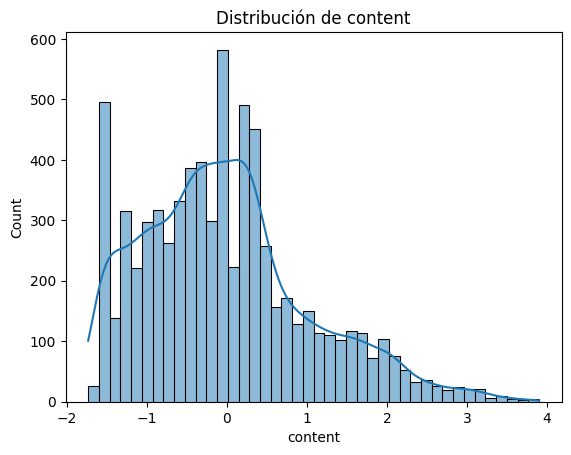

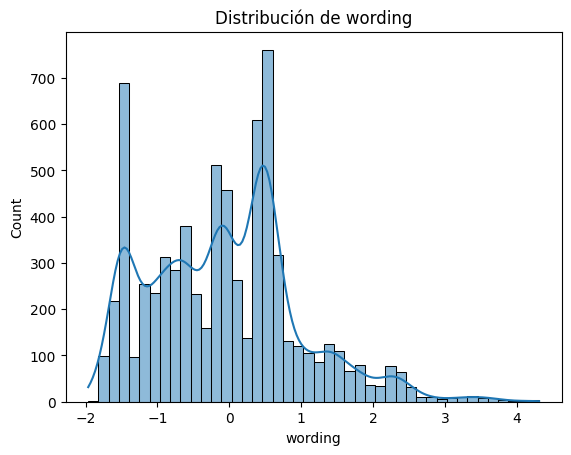

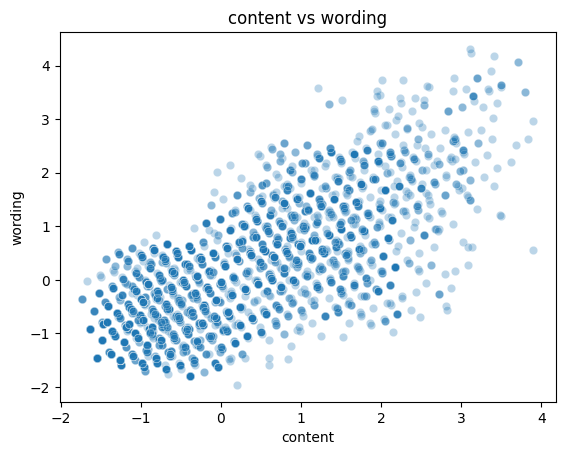

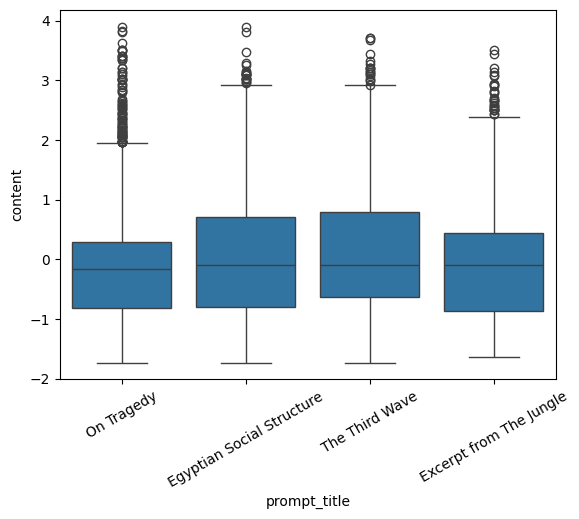

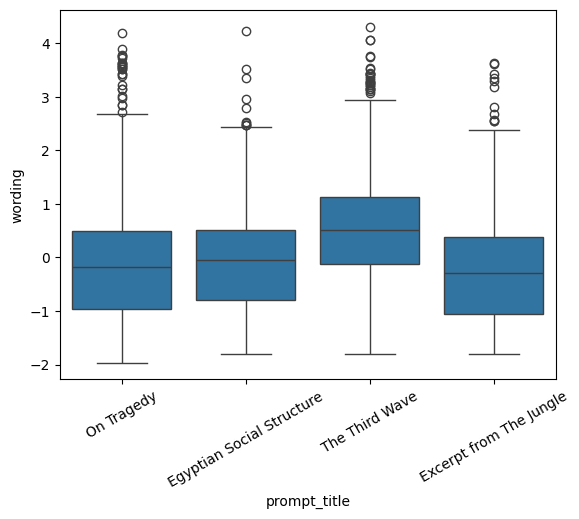

In [14]:
# Histogramas
for col in ['content','wording']:
    sns.histplot(df_merged[col], kde=True); plt.title(f'Distribución de {col}'); plt.show()

# Dispersión content vs wording
sns.scatterplot(data=df_merged, x='content', y='wording', alpha=0.3)
plt.title('content vs wording'); plt.show()

# Boxplots por prompt
sns.boxplot(data=df_merged, x='prompt_title', y='content'); plt.xticks(rotation=30); plt.show()
sns.boxplot(data=df_merged, x='prompt_title', y='wording'); plt.xticks(rotation=30); plt.show()


,n_words,n_chars
count,7165.000000,7165.000000
mean,74.811724,418.784368
std,53.503992,307.837946
min,22.000000,114.000000
25%,39.000000,216.000000
50%,58.000000,320.000000
75%,92.000000,513.000000
max,647.000000,3940.000000


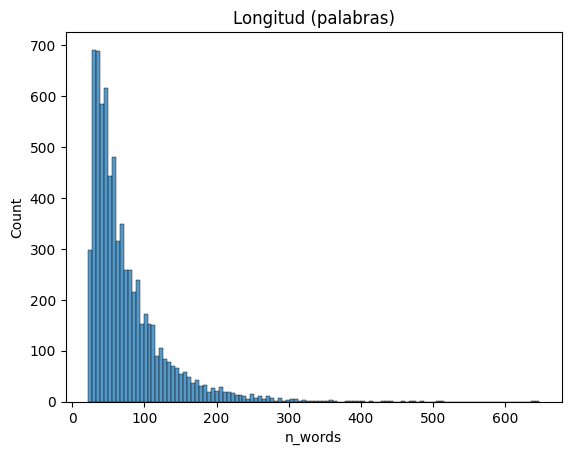

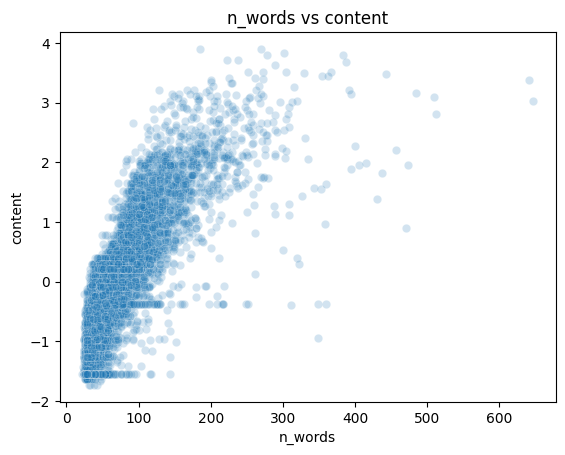

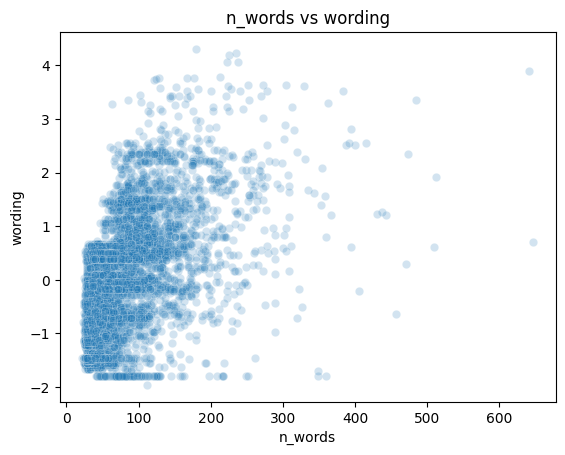

In [15]:
# Longitud de textos y su relacion con las notas
df_merged['n_words'] = df_merged['text'].str.split().str.len()
df_merged['n_chars'] = df_merged['text'].str.len()
display(df_merged[['n_words','n_chars']].describe())

sns.histplot(df_merged['n_words']); plt.title('Longitud (palabras)'); plt.show()
sns.scatterplot(data=df_merged, x='n_words', y='content', alpha=0.2); plt.title('n_words vs content'); plt.show()
sns.scatterplot(data=df_merged, x='n_words', y='wording', alpha=0.2); plt.title('n_words vs wording'); plt.show()


En este conjunto de resúmenes, las notas de **content** y **wording** se concentran cerca de cero (ligeramente hacia lo negativo) y tienen una “cola” hacia valores altos, o sea, hay pocos trabajos muy bien calificados. Ambas dimensiones suben y bajan juntas de forma clara (los puntos del scatter forman una diagonal), así que cuando mejora el contenido también suele mejorar la redacción. Por tema, **“The Third Wave”** muestra las medianas más altas y **“On Tragedy”** las más bajas, mientras que los otros dos quedan en medio. La mayoría de textos son **cortos** (mediana \~58 palabras) pero existe una minoría muy larga; en general, escribir un poco más se asocia con mejores notas, aunque después de \~150–200 palabras ya no se ve un aumento tan claro. En resumen, las calificaciones dependen del prompt y están relacionadas entre sí, y la longitud ayuda hasta cierto punto.
